In [1]:
import numpy as np
import tensorflow as tf
import keras
import os
import sys
from tqdm import tqdm
import time
import keras.backend as K

2022-04-12 23:11:53.532609: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
sys.path.append('..')

In [3]:
import nets
from Data import datagen
import importlib 
importlib.reload(datagen)  # Python 3.4+

<module 'Data.datagen' from '/home/keondopark/sleep/JupyterNotebooks/../Data/datagen.py'>

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], 
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*6)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs 1 Logical GPUs


2022-04-12 23:11:59.821796: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-04-12 23:11:59.892963: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:25:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2022-04-12 23:11:59.893388: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-04-12 23:12:00.129620: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-04-12 23:12:00.129674: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2022-04-12 23:12:00.149267: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcu

In [5]:
np.random.seed(1)

In [6]:
PROCESSED_DATA_PATH = os.path.join('/home','aiot','data','origin_npy')
save_signals_path_SC = os.path.join(PROCESSED_DATA_PATH,'signals_SC_filtered')
save_annotations_path_SC = os.path.join(PROCESSED_DATA_PATH,'annotations_SC')
save_signals_path_ST = os.path.join(PROCESSED_DATA_PATH,'signals_ST_filtered')
save_annotations_path_ST = os.path.join(PROCESSED_DATA_PATH,'annotations_ST')

save_signals_path_SC_seq = os.path.join(PROCESSED_DATA_PATH,'signals_SC_seq')
save_annotations_path_SC_seq = os.path.join(PROCESSED_DATA_PATH,'annotations_SC_seq')
save_signals_path_ST_seq = os.path.join(PROCESSED_DATA_PATH,'signals_ST_seq')
save_annotations_path_ST_seq = os.path.join(PROCESSED_DATA_PATH,'annotations_ST_seq')

In [7]:
def match_annotations_npy(dirname, filepath):
    filename = os.path.basename(filepath)
    search_filename = filename.split('-')[0][:-2]
    file_list = os.listdir(dirname)
    filenames = [file for file in file_list if search_filename in file if file.endswith('.npy')]
    return filenames

In [8]:
dim_HT1D = (3000,1)
n_classes=6
epochs = 50
bs = 64
BASE_LEARNING_RATE = 1e-3
data_ratio = 0.25
PREV_CNT = 10
list_files_SC = [os.path.join(save_signals_path_SC, f) for f in os.listdir(save_signals_path_SC) if f.endswith('.npy')]
list_files_ST = [os.path.join(save_signals_path_ST, f) for f in os.listdir(save_signals_path_ST) if f.endswith('.npy')]

In [9]:
def read_csv_to_list(filepath):
    import csv
    with open(filepath, newline='') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',')
        list_filepath = [row[0] for row in spamreader]
    return list_filepath

In [10]:
list_files_SC = [os.path.join(save_signals_path_SC, f) for f in os.listdir(save_signals_path_SC) if f.endswith('.npy')]
list_files_ST = [os.path.join(save_signals_path_ST, f) for f in os.listdir(save_signals_path_ST) if f.endswith('.npy')]

list_files_SC_seq = [os.path.join(save_signals_path_SC_seq, f) for f in os.listdir(save_signals_path_SC_seq) if f.endswith('.npy')]
list_files_ST_seq = [os.path.join(save_signals_path_ST_seq, f) for f in os.listdir(save_signals_path_ST_seq) if f.endswith('.npy')]

train_test_split = 0.7
split_cnt_SC = int(train_test_split * len(list_files_SC))
split_cnt_ST = int(train_test_split * len(list_files_ST))

include_SC = True
include_ST = True

list_files_train = []
list_files_test = []

list_seq_files_train = []
list_seq_files_test = []

list_ann_files_train = []
list_ann_files_test = []

list_ann_seq_files_train = []
list_ann_seq_files_test = []

if include_SC:
    list_files_SC_train = np.random.choice(list_files_SC[:split_cnt_SC], int(float(data_ratio) * split_cnt_SC), replace=False)
    list_files_train += list_files_SC_train.tolist()

    for f in list_files_SC_train:
        ann_file = match_annotations_npy(save_annotations_path_SC, f)
        list_ann_files_train.append(os.path.join(save_annotations_path_SC, ann_file[0]))

        list_seq_files_train.append(os.path.join(save_signals_path_SC_seq, os.path.basename(f)))
        list_ann_seq_files_train.append(os.path.join(save_annotations_path_SC_seq, ann_file[0]))
    
    list_files_test += list_files_SC[split_cnt_SC:]

    for f in list_files_SC[split_cnt_SC:]:
        ann_file = match_annotations_npy(save_annotations_path_SC, f)
        list_ann_files_test.append(os.path.join(save_annotations_path_SC, ann_file[0]))
        list_seq_files_test.append(os.path.join(save_signals_path_SC_seq, os.path.basename(f)))
        list_ann_seq_files_test.append(os.path.join(save_annotations_path_SC_seq, ann_file[0]))




if include_ST:
    list_files_ST_train = np.random.choice(list_files_ST[:split_cnt_ST], int(float(data_ratio) * split_cnt_ST), replace=False)
    list_files_train += list_files_ST_train.tolist()
    for f in list_files_ST_train:
        ann_file = match_annotations_npy(save_annotations_path_ST, f)
        list_ann_files_train.append(os.path.join(save_annotations_path_ST, ann_file[0]))
        list_seq_files_train.append(os.path.join(save_signals_path_ST_seq, os.path.basename(f)))
        list_ann_seq_files_train.append(os.path.join(save_annotations_path_ST_seq, ann_file[0]))

    list_files_test += list_files_ST[split_cnt_ST:]
    for f in list_files_ST[split_cnt_ST:]:
        ann_file = match_annotations_npy(save_annotations_path_ST, f)
        list_ann_files_test.append(os.path.join(save_annotations_path_ST, ann_file[0]))
        list_seq_files_test.append(os.path.join(save_signals_path_ST_seq, os.path.basename(f)))
        list_ann_seq_files_test.append(os.path.join(save_annotations_path_ST_seq, ann_file[0]))

# Generator for training the model predicting from single epoch
#train_generator = datagen.DataGenerator(list_files_train, list_ann_files_train, 
#                          batch_size=bs, dim=dim_HT1D, n_classes=n_classes, shuffle=True)
#test_generator = datagen.DataGenerator(list_files_test, list_ann_files_test, 
#                          batch_size=bs, dim=dim_HT1D, n_classes=n_classes, shuffle=False)

#train_generator2 = datagen.DataGenerator(list_seq_files_train, list_ann_seq_files_train, 
#                          batch_size=bs, dim=(PREV_CNT+1,) + dim_HT1D, n_classes=n_classes, shuffle=True)
test_generator2 = datagen.DataGenerator(list_seq_files_test, list_ann_seq_files_test, 
                          batch_size=bs, dim=(PREV_CNT+1,) + dim_HT1D, n_classes=n_classes, shuffle=False)

In [17]:
model2 = nets.Conv1DASPP_multi2(batch_size=bs, prev_cnt=PREV_CNT)

In [18]:
x2 = np.random.random((bs,PREV_CNT+1, 3000,1))
x2 = tf.convert_to_tensor(x2)
model2(x2)
print(model2.summary())

Model: "conv1daspp_multi2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1daspp_layer_1 (Conv1DAS multiple                  3379456   
_________________________________________________________________
multihead_cross_attention (M multiple                  197376    
_________________________________________________________________
dense_5 (Dense)              multiple                  65792     
_________________________________________________________________
layer_normalization (LayerNo multiple                  512       
_________________________________________________________________
dense_6 (Dense)              multiple                  168966    
Total params: 3,812,102
Trainable params: 3,806,406
Non-trainable params: 5,696
_________________________________________________________________
None


In [19]:
def get_current_lr(epoch):
    lr = BASE_LEARNING_RATE
    for _ in range(epoch // 10):
        lr *= 0.1
    return lr

def adjust_learning_rate(optimizer, epoch):
    lr = get_current_lr(epoch)
    optimizer.learning_rate = lr

In [20]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

In [21]:
ckpt2 = tf.train.Checkpoint(step=tf.Variable(0), optimizer=optimizer, net=model2)
manager2 = tf.train.CheckpointManager(ckpt2, '../tf_ckpt/ckpt_' + model2.name, max_to_keep=1)

In [22]:
status = ckpt2.restore(tf.train.latest_checkpoint('../tf_ckpt/ckpt_' + model2.name))

In [23]:
#if manager2.latest_checkpoint:
#    ckpt2.restore(manager2.latest_checkpoint)
#    print("Restored")
#    start_epoch = ckpt2.step.numpy()

In [24]:
correct, total_cnt, total_loss = 0.0, 0.0, 0.0
start = time.time()
y_list, y_pred_list = [], []
for idx, (x, y) in enumerate(test_generator2):
    y_pred = model2(x, training=False)
    y_pred_cls = tf.math.argmax(y_pred, axis=-1)
    y_pred_list.append(y_pred_cls)
    correct += tf.reduce_sum(tf.cast(tf.equal(y_pred_cls, y), tf.float32))
    total_cnt += y_pred.shape[0]
    y = tf.cast(y, dtype=tf.int32)  
    y_list.append(y)
    total_loss += loss_fn(y, y_pred).numpy() * y_pred.shape[0]    

    test_acc = correct / total_cnt
    test_loss = total_loss / total_cnt
    if (idx + 1) % 10 == 0 or idx+1 == len(test_generator2):
        print("[%d / %d] test loss: %.6f, test accuracy: %.3f"%
              (idx+1, len(test_generator2), test_loss, test_acc),end='\r', flush=True)
print("")
print("Eval time: %.2f sec"%(time.time() - start))

[2131 / 2131] test loss: 1.149061, test accuracy: 0.869
Eval time: 1169.72 sec


In [25]:
import matplotlib.pyplot as plt

In [26]:
y_pred_all = np.concatenate(y_pred_list)
y_all = np.concatenate(y_list)

In [54]:
y_pred_by_patient = []
y_by_patient = []
start = 0
for cnt in test_generator2.list_cnt:
    y_pred_by_patient.append(y_pred_all[start:start+cnt])
    y_by_patient.append(y_all[start:start+cnt])
    start += cnt
    

In [55]:
confusion_matrix = np.zeros((n_classes,n_classes))
y = tf.cast(y, dtype=tf.int32)    
for i in range(n_classes):
    for j in range(n_classes):
        confusion_matrix[i,j] += np.sum((y_pred_all==i) * (y_all==j))

In [56]:
print('-'*20 + 'Confusion Matrix' + '-'*20)
for i in range(n_classes):
    print_ln = ""
    for j in range(n_classes):
        print_ln += "%.3f "%(confusion_matrix[i,j] / np.sum(confusion_matrix[i]))
    print(print_ln)
    
print('-'*20 + 'Confusion Matrix counts' + '-'*20)
for i in range(n_classes):
    print_ln = ""
    for j in range(n_classes):
        print_ln += "%d "%(confusion_matrix[i,j])
    print(print_ln)

--------------------Confusion Matrix--------------------
0.961 0.017 0.005 0.001 0.006 0.011 
0.254 0.396 0.211 0.005 0.134 0.000 
0.017 0.083 0.793 0.036 0.071 0.001 
0.007 0.029 0.353 0.575 0.036 0.001 
0.062 0.107 0.098 0.003 0.730 0.001 
0.325 0.128 0.173 0.361 0.006 0.006 
--------------------Confusion Matrix counts--------------------
83830 1443 409 62 510 938 
1109 1728 919 21 585 2 
452 2233 21442 979 1918 29 
54 222 2693 4386 271 5 
594 1019 938 29 6982 5 
109 43 58 121 2 2 


In [60]:
p_idx = 1
obs_len = 400

In [61]:
test_generator2[0][0].shape

(64, 11, 3000, 1)

In [62]:
test_generator2[1]

(array([[[[ 0.0547239 ],
          [ 0.26828253],
          [ 0.6199107 ],
          ...,
          [ 0.7355756 ],
          [ 1.0064778 ],
          [ 1.1006563 ]],
 
         [[ 0.05131072],
          [ 0.29051712],
          [ 0.6157106 ],
          ...,
          [-0.01012387],
          [-0.1616624 ],
          [-0.07077299]],
 
         [[-0.03759644],
          [-0.24855499],
          [-0.62924415],
          ...,
          [-1.7226909 ],
          [-1.6883574 ],
          [-1.6434124 ]],
 
         ...,
 
         [[-0.04915861],
          [-0.2739205 ],
          [-0.63744724],
          ...,
          [-0.06626432],
          [-0.02997765],
          [ 0.05738074]],
 
         [[-0.09670595],
          [-0.6000468 ],
          [-1.3538058 ],
          ...,
          [-1.466484  ],
          [-0.4085798 ],
          [-0.5149938 ]],
 
         [[ 0.0378954 ],
          [ 0.17572506],
          [ 0.441526  ],
          ...,
          [-1.5117931 ],
          [-1.457302  ],
    

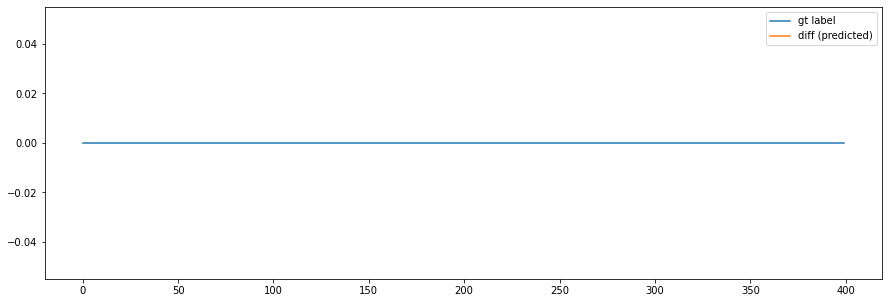

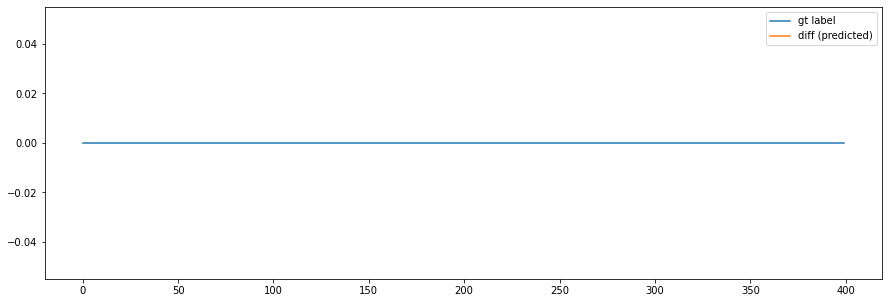

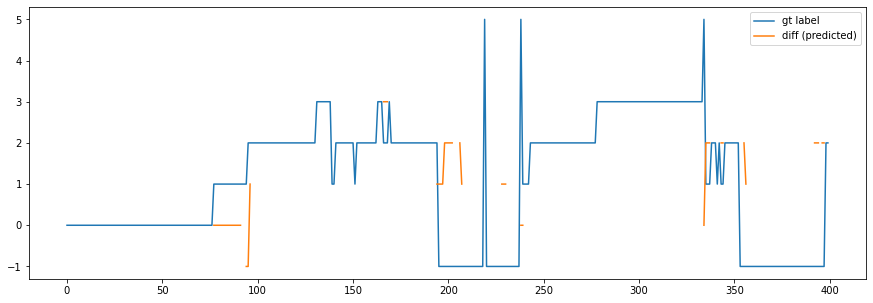

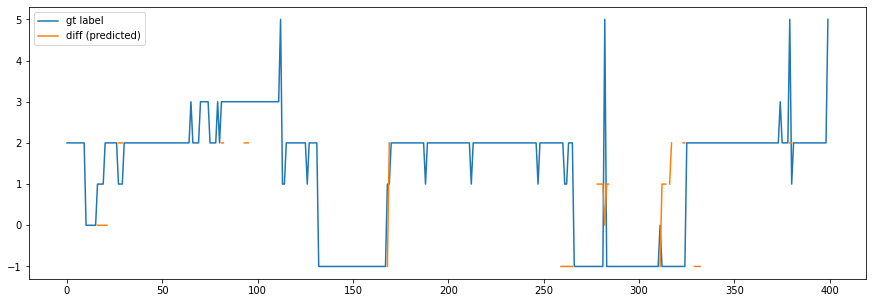

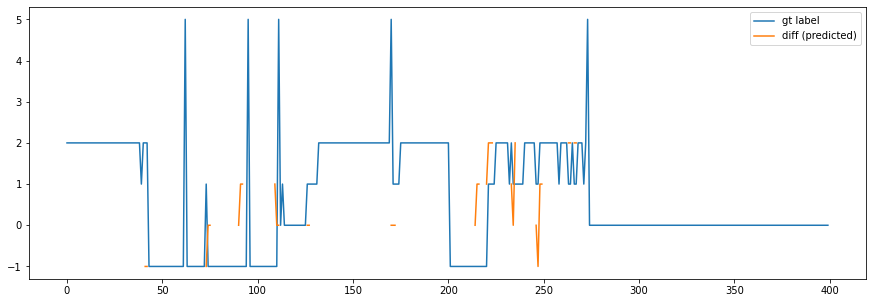

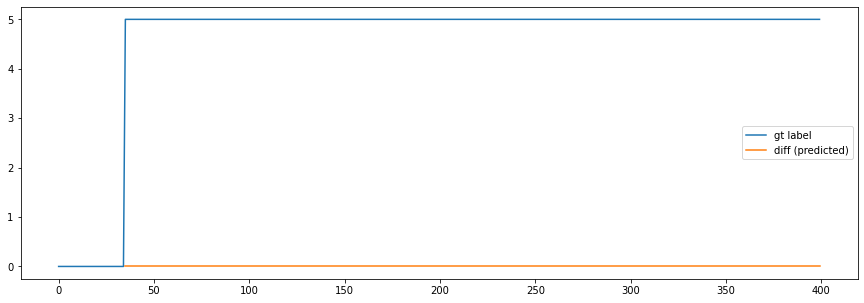

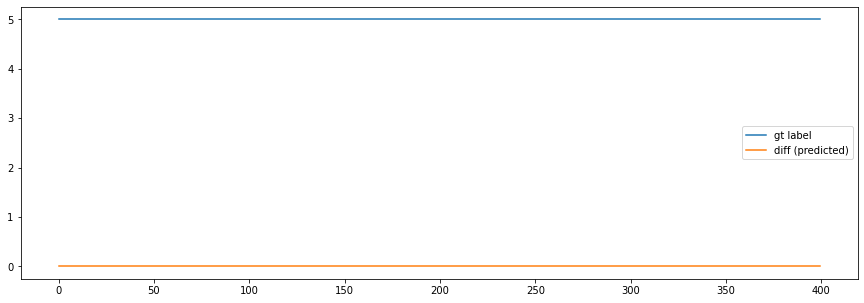

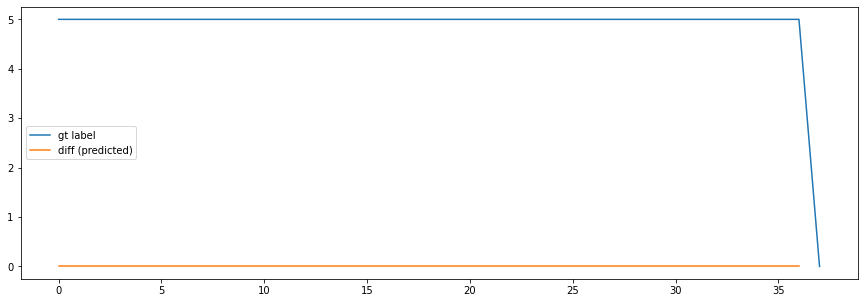

In [63]:
pred = y_pred_by_patient[p_idx]
gt = y_by_patient[p_idx]
pred[pred == 4] = -1
gt[gt == 4] = -1
diff = np.where(pred == gt, None, pred)
for i in range((len(pred - 10) - 1) // obs_len + 1):
    plt.figure(figsize=(15,5))
    plt.plot(gt[10 + obs_len * i:10 + obs_len * (i+1)], label='gt label')    
    plt.plot(diff[10 + obs_len * i:10 + obs_len * (i+1)], label='diff (predicted)')
    plt.legend()

In [101]:
model2 = nets.Conv1DASPP_multi(batch_size=bs, prev_cnt=PREV_CNT)

In [108]:
x2 = np.random.random((bs,PREV_CNT+1, 3000,1))
x2 = tf.convert_to_tensor(x2)
model2(x2)
print(model2.summary())

Model: "conv1daspp_multi"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1daspp_layer_1 (Conv1DAS multiple                  3379456   
_________________________________________________________________
dense_3 (Dense)              multiple                  168966    
Total params: 3,548,422
Trainable params: 3,542,726
Non-trainable params: 5,696
_________________________________________________________________
None


In [105]:
ckpt2 = tf.train.Checkpoint(step=tf.Variable(0), optimizer=optimizer, net=model2)
manager2 = tf.train.CheckpointManager(ckpt2, '../tf_ckpt/ckpt_' + model2.name, max_to_keep=1)

In [106]:
if manager2.latest_checkpoint:
    ckpt2.restore(manager2.latest_checkpoint)
    start_epoch = ckpt2.step.numpy()-1

ValueError: Shapes (28160, 6) and (2560, 6) are incompatible

In [104]:
correct, total_cnt, total_loss = 0.0, 0.0, 0.0
start = time.time()
y_list2, y_pred_list2 = [], []
for idx, (x, y) in enumerate(test_generator2):
    y_pred = model2(x, training=False)
    y_pred_cls = tf.math.argmax(y_pred, axis=-1)
    y_pred_list2.append(y_pred_cls)
    correct += tf.reduce_sum(tf.cast(tf.equal(y_pred_cls, y), tf.float32))
    total_cnt += y_pred.shape[0]
    y = tf.cast(y, dtype=tf.int32)  
    y_list2.append(y)
    total_loss += loss_fn(y, y_pred).numpy() * y_pred.shape[0]    

    test_acc = correct / total_cnt
    test_loss = total_loss / total_cnt
    if (idx + 1) % 10 == 0 or idx+1 == len(test_generator2):
        print("[%d / %d] test loss: %.6f, test accuracy: %.3f"%
              (idx+1, len(test_generator2), test_loss, test_acc),end='\r', flush=True)
print("")
print("Eval time: %.2f sec"%(time.time() - start))

KeyboardInterrupt: 